<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM/LSTM_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 69), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (144/144), 119.43 KiB | 5.19 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 14 13:39:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Amazon'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 12.6MB/s 
     |████████████████████████████████| 174kB 49.4MB/s 
     |████████████████████████████████| 143kB 52.4MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()

    # input layer
    model.add(LSTM(units=config.input_size, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # second model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # third model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # fourth model layer with dropout
    model.add(LSTM(units=config.hidden_size, activation=config.activation))
    model.add(Dropout(config.dropout))
    # final layer with one output
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: ans6cuu1
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM/sweeps/ans6cuu1


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: sp0xhah6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 23s 249ms/step - loss: 0.1730 - mean_squared_error: 0.1730 - mean_absolute_error: 0.3158 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1446
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1245 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1106
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1043 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1467
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0973 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1149
Epoch 5/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0137 - mean_squared_error: 0

epoch,11
loss,0.01105
mean_squared_error,0.01105
mean_absolute_error,0.07465
val_loss,0.01732
val_mean_squared_error,0.01732
val_mean_absolute_error,0.10995
_runtime,33
_timestamp,1626270115
_step,11
best_val_loss,0.01633


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▁▁▁▁▁▁
val_loss,▇▁▆▂▄▃▂▂▂▅█▁
val_mean_squared_error,▇▁▆▂▄▃▂▂▂▅█▁
val_mean_absolute_error,▆▁▆▂▂▁▁▁▁▂█▁
_runtime,▁▅▅▅▅▅▅▅▅███
_timestamp,▁▅▅▅▅▅▅▅▅███
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: hoz8o2yx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 7s 109ms/step - loss: 2.4347 - mean_squared_error: 2.4347 - mean_absolute_error: 0.9063 - val_loss: 0.0562 - val_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.1854
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.1314 - mean_squared_error: 0.1314 - mean_absolute_error: 0.2974 - val_loss: 0.0985 - val_mean_squared_error: 0.0985 - val_mean_absolute_error: 0.2603
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0923 - mean_squared_error: 0.0923 - mean_absolute_error: 0.2526 - val_loss: 0.0999 - val_mean_squared_error: 0.0999 - val_mean_absolute_error: 0.2653
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1788 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1664
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0558 - mean_squared

epoch,20
loss,0.00967
mean_squared_error,0.00967
mean_absolute_error,0.07322
val_loss,0.02171
val_mean_squared_error,0.02171
val_mean_absolute_error,0.10538
_runtime,17
_timestamp,1626270145
_step,20
best_val_loss,0.0202


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▃▆▆▂▃█▄▅▁▁▁▁▂▃▁▂▃▁▂▁▁
val_mean_squared_error,▃▆▆▂▃█▄▅▁▁▁▁▂▃▁▂▃▁▂▁▁
val_mean_absolute_error,▄▆▆▃▄█▅▆▁▁▁▁▂▃▂▂▃▂▂▁▁
_runtime,▁▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇███
_timestamp,▁▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: h392gxmb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 122ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - mean_absolute_error: 0.2316 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1108
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0670 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1055
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0520 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1037
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0588 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1139
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0071 - mean_squared_erro

epoch,49
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.04049
val_loss,0.02085
val_mean_squared_error,0.02085
val_mean_absolute_error,0.10634
_runtime,28
_timestamp,1626270184
_step,49
best_val_loss,0.01109


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▄▃▃▃▃▃▂▄▅▅▅▆▂▃▃▂▂▃▆▁▃▁▂▂▃▁▂▁▁▂▁▅▄▁▆
val_mean_squared_error,█▅▅▄▃▄▃▃▃▃▃▂▄▅▅▅▆▂▃▃▂▂▃▆▁▃▁▂▂▃▁▂▁▁▂▁▅▄▁▆
val_mean_absolute_error,▅▄▄▆▄▃▃▃▃▄▃▃▆▃█▄█▃▂▂▂▂▂▄▂▂▂▁▁▅▃▃▁▁▁▁▄▃▁▄
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ndokym3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 60ms/step - loss: 0.1355 - mean_squared_error: 0.1355 - mean_absolute_error: 0.2813 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1412
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0798 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1062
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0612 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1035
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0615 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1071
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0066 - mean_squared_error

epoch,49
loss,0.00356
mean_squared_error,0.00356
mean_absolute_error,0.04262
val_loss,0.014
val_mean_squared_error,0.014
val_mean_absolute_error,0.08675
_runtime,34
_timestamp,1626270233
_step,49
best_val_loss,0.01162


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▄▃▃▃▄▄▃▃▂▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂
val_mean_squared_error,█▄▃▃▃▄▃▃▃▄▄▃▃▂▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▃▃▄▃▃▃▃▃▂▂▃▂▃▂▂▃▂▂▃▂▂▂▂▂▂▃▂▂▂▁▁▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8k3uvgfu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 8s 114ms/step - loss: 0.0888 - mean_squared_error: 0.0888 - mean_absolute_error: 0.2021 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1155
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0606 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1163
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0468 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1141
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0463 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1046
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_squared

epoch,99
loss,0.00194
mean_squared_error,0.00194
mean_absolute_error,0.03246
val_loss,0.00855
val_mean_squared_error,0.00855
val_mean_absolute_error,0.07065
_runtime,43
_timestamp,1626270304
_step,99
best_val_loss,0.00855


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▅█▃▃▄▅▄▃▆▃▂▃▃▃▃▂▂▂▂▂▂▃▂▁▁▁▂▁▁▂▁▅▁▁▁▁▁▁
val_mean_squared_error,▄▄▅█▃▃▄▅▄▃▆▃▂▃▃▃▃▂▂▂▂▂▂▃▂▁▁▁▂▁▁▂▁▅▁▁▁▁▁▁
val_mean_absolute_error,▇▇▅█▅▅▄▅▇▄▆▃▄▃▃▆▄▃▃▃▃▄▂▃▂▂▂▂▂▂▃▃▁▅▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9zyfm0vs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 121ms/step - loss: 0.0683 - mean_squared_error: 0.0683 - mean_absolute_error: 0.1838 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1084
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0793 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1315
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0888 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1290
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0782 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1243
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0092 - mean_squared

epoch,99
loss,0.00308
mean_squared_error,0.00308
mean_absolute_error,0.04147
val_loss,0.01081
val_mean_squared_error,0.01081
val_mean_absolute_error,0.07787
_runtime,34
_timestamp,1626270357
_step,99
best_val_loss,0.00846


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▄▄▄▅▅▃▃▃▅▄▂▂▃▂▂▂▂▂▂▃▁▁▃▁▂▂▂▂▁▁▁▁▃▁▂▁▁▂
val_mean_squared_error,▄█▄▄▄▅▅▃▃▃▅▄▂▂▃▂▂▂▂▂▂▃▁▁▃▁▂▂▂▂▁▁▁▁▃▁▂▁▁▂
val_mean_absolute_error,▅▇▄▄▄▅▅▅▅▅█▄▃▃▃▃▄▃▃▂▄▅▂▂▅▂▂▂▄▂▂▁▁▂▃▂▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g68f92y9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 8s 61ms/step - loss: 0.0781 - mean_squared_error: 0.0781 - mean_absolute_error: 0.1915 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1188
Epoch 2/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0849 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1004
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0715 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1199
Epoch 4/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0582 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0963
Epoch 5/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0069 - mean_squared_error

epoch,49
loss,0.003
mean_squared_error,0.003
mean_absolute_error,0.04004
val_loss,0.00921
val_mean_squared_error,0.00921
val_mean_absolute_error,0.07787
_runtime,39
_timestamp,1626270408
_step,49
best_val_loss,0.00886


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▅▃▃▅▃▄▂▂▂▂▂▄▄▂▅▃▂▂▂▃▂▄▂▁▇▁▁▂▁▁▁▂▂▃▁▁▁
val_mean_squared_error,█▄▄▅▃▃▅▃▄▂▂▂▂▂▄▄▂▅▃▂▂▂▃▂▄▂▁▇▁▁▂▁▁▁▂▂▃▁▁▁
val_mean_absolute_error,▆▄▆▃▅▃▇▃▆▃▃▃▃▄▃▃▃▆▂▂▂▃▂▂▃▂▂█▂▁▁▁▁▁▂▃▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rjd1htsg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 62ms/step - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.2013 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0993
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0534 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0971
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0464 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1165
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0450 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0960
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error

epoch,49
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.03137
val_loss,0.00866
val_mean_squared_error,0.00866
val_mean_absolute_error,0.07255
_runtime,34
_timestamp,1626270453
_step,49
best_val_loss,0.00866


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▇█▆▅▅▆▅▅▄▅▄▄▄▄▃▇▄▃▃▃▃▄▂▂▃▂▃▄▂▂▂▂▃▁▂▁▁▁
val_mean_squared_error,▇▇▇█▆▅▅▆▅▅▄▅▄▄▄▄▃▇▄▃▃▃▃▄▂▂▃▂▃▄▂▂▂▂▃▁▂▁▁▁
val_mean_absolute_error,▅▅█▅▅▆▅▄▅▄▄▃▃▅▃▃▃▄▃▃▃▄▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2cr1vi9g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 110ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.2298 - val_loss: 0.0498 - val_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.1967
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0927 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1425
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0680 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1783
Epoch 4/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0801 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1151
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0099 - mean_squared

epoch,75
loss,0.00438
mean_squared_error,0.00438
mean_absolute_error,0.04617
val_loss,0.01447
val_mean_squared_error,0.01447
val_mean_absolute_error,0.0891
_runtime,30
_timestamp,1626270498
_step,75
best_val_loss,0.01016


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▆▄▄▃▄▂▃▄▂▂▄▂▃▂▄▂▂▂▁▁▃▃▁▁▁▂▂▁▁▃▂▁▃▂▂▁▂
val_mean_squared_error,█▄▄▆▄▄▃▄▂▃▄▂▂▄▂▃▂▄▂▂▂▁▁▃▃▁▁▁▂▂▁▁▃▂▁▃▂▂▁▂
val_mean_absolute_error,█▅▃▇▃▃▄▅▂▄▅▃▂▄▂▄▂▅▂▂▂▁▂▃▂▁▂▁▂▁▁▂▃▁▁▃▂▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ziunkvk9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 7s 247ms/step - loss: 0.1966 - mean_squared_error: 0.1966 - mean_absolute_error: 0.3480 - val_loss: 0.1712 - val_mean_squared_error: 0.1712 - val_mean_absolute_error: 0.3773
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0777 - mean_squared_error: 0.0777 - mean_absolute_error: 0.2142 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1127
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1694 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0993
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1443 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1438
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0249 - mean_squared_error: 0.0249 

epoch,15
loss,0.01143
mean_squared_error,0.01143
mean_absolute_error,0.07481
val_loss,0.01688
val_mean_squared_error,0.01688
val_mean_absolute_error,0.11048
_runtime,15
_timestamp,1626270544
_step,15
best_val_loss,0.01592


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▃▃▃▃▃▃▆▆▆▆▆▆▆██
_timestamp,▁▃▃▃▃▃▃▆▆▆▆▆▆▆██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: ab1cfxcu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 145ms/step - loss: 0.1549 - mean_squared_error: 0.1549 - mean_absolute_error: 0.2966 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1194
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1447 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1015
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0853 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1153
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0768 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1073
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0131 - mean_squared_erro

epoch,49
loss,0.00585
mean_squared_error,0.00585
mean_absolute_error,0.0547
val_loss,0.01415
val_mean_squared_error,0.01415
val_mean_absolute_error,0.08839
_runtime,25
_timestamp,1626270583
_step,49
best_val_loss,0.01205


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▃▃▃▃▂▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▃▄▃▃▃▃▂▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▄▇▅▄▃▃▅▇▄▃▃▃▃▅▃▃▅▃▃▂▅▃▄▅▄▂▁▁▂▂▂▂▂▁▁▂▃▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 66swtqp1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 8s 114ms/step - loss: 0.2069 - mean_squared_error: 0.2069 - mean_absolute_error: 0.2936 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1024
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0634 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0965
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0781 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0942
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0496 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0924
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0107 - mean_squared

epoch,99
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.0283
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.05602
_runtime,45
_timestamp,1626270645
_step,99
best_val_loss,0.00391


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃█▅▃▃▇▇▅▅▃▂▂▂▄▃▃▂▂▃▄▄▂▄▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃█▅▃▃▇▇▅▅▃▂▂▂▄▃▃▂▂▃▄▄▂▄▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▅█▇▅▄█▇▅▅▄▃▃▃▆▄▄▃▃▅▅▅▃▅▂▂▂▂▁▂▂▃▁▂▁▂▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6ey4sk32 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 114ms/step - loss: 0.0964 - mean_squared_error: 0.0964 - mean_absolute_error: 0.2294 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1791
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0994 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1401
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0616 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1249
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0521 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1030
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0038 - mean_squared

epoch,99
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.02909
val_loss,0.0089
val_mean_squared_error,0.0089
val_mean_absolute_error,0.07026
_runtime,40
_timestamp,1626270705
_step,99
best_val_loss,0.00864


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gcl67z5k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 228ms/step - loss: 0.1158 - mean_squared_error: 0.1158 - mean_absolute_error: 0.2530 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1039
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0820 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1882
Epoch 3/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0821 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1055
Epoch 4/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0664 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1099
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0078 - mean_squared_error: 0.

epoch,148
loss,0.00249
mean_squared_error,0.00249
mean_absolute_error,0.03563
val_loss,0.009
val_mean_squared_error,0.009
val_mean_absolute_error,0.07681
_runtime,41
_timestamp,1626270758
_step,148
best_val_loss,0.00888


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▃▃▂▃▃▄▂▃▄▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
mean_squared_error,█▇▃▃▂▃▃▄▂▃▄▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▃▃▃▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▃▃▂▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pd6jkq6k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 8s 112ms/step - loss: 0.6553 - mean_squared_error: 0.6553 - mean_absolute_error: 0.4193 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1249
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0873 - val_loss: 0.0810 - val_mean_squared_error: 0.0810 - val_mean_absolute_error: 0.2474
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1031 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0984
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0414 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0922
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0048 - mean_squared

epoch,150
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02283
val_loss,0.00356
val_mean_squared_error,0.00356
val_mean_absolute_error,0.04975
_runtime,62
_timestamp,1626270832
_step,150
best_val_loss,0.00266


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▁▂▂▁▂▃▂▁▁▂▁▁▂▂▁▂▁▁▁▁▁
val_loss,█▂▂▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▄▄▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▃▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: r3e3al6q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 310ms/step - loss: 0.2283 - mean_squared_error: 0.2283 - mean_absolute_error: 0.3498 - val_loss: 0.1439 - val_mean_squared_error: 0.1439 - val_mean_absolute_error: 0.3384
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.1867 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1671
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1233 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0925
Epoch 4/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0549 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0880
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0062 - mean_squared_error: 0.

epoch,68
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.03539
val_loss,0.01108
val_mean_squared_error,0.01108
val_mean_absolute_error,0.07764
_runtime,26
_timestamp,1626270871
_step,68
best_val_loss,0.0076


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▃▁▁▂▁▁▂▃▂▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dced8mge with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 80ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - mean_absolute_error: 0.1625 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1062
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0671 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1051
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0594 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1029
Epoch 4/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0589 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0954
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0059 - mean_squared_error

epoch,49
loss,0.00234
mean_squared_error,0.00234
mean_absolute_error,0.0358
val_loss,0.00854
val_mean_squared_error,0.00854
val_mean_absolute_error,0.07629
_runtime,36
_timestamp,1626270928
_step,49
best_val_loss,0.0076


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▃▄▇▃▃▇▃▃▃█▂▂▂█▂▃▂▂▂▂▂▃▂█▁▂▂▂▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▄▄▃▄▇▃▃▇▃▃▃█▂▂▂█▂▃▂▂▂▂▂▃▂█▁▂▂▂▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▅▅▅▄▇▅▄▆▃▃▆▇▃▃▄▇▃▅▃▂▃▂▂▃▃█▂▂▂▂▁▁▁▁▂▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: omnki9w6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 308ms/step - loss: 0.1848 - mean_squared_error: 0.1848 - mean_absolute_error: 0.3360 - val_loss: 0.0724 - val_mean_squared_error: 0.0724 - val_mean_absolute_error: 0.2333
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1502 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1125
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1172 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1579
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1016 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0958
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078 

epoch,49
loss,0.00274
mean_squared_error,0.00274
mean_absolute_error,0.03896
val_loss,0.01342
val_mean_squared_error,0.01342
val_mean_absolute_error,0.0911
_runtime,22
_timestamp,1626270964
_step,49
best_val_loss,0.01293


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▄▁▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lb4725uc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 121ms/step - loss: 0.0994 - mean_squared_error: 0.0994 - mean_absolute_error: 0.2236 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1070
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0730 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1138
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0690 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1190
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0593 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1071
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0084 - mean_squared

epoch,50
loss,0.00382
mean_squared_error,0.00382
mean_absolute_error,0.04356
val_loss,0.01226
val_mean_squared_error,0.01226
val_mean_absolute_error,0.08129
_runtime,26
_timestamp,1626271005
_step,50
best_val_loss,0.01096


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,▄▇▄▅▄█▅▄▃▅▃▅▄▂▃▂▄▂▂▅▃▂▂▂▂▁▄▄▁▂▁▁▁▂▂▂█▁▁▁
val_mean_squared_error,▄▇▄▅▄█▅▄▃▅▃▅▄▂▃▂▄▂▂▅▃▂▂▂▂▁▄▄▁▂▁▁▁▂▂▂█▁▁▁
val_mean_absolute_error,▄▅▆▄▄▆▄▇▆▄▅█▃▃▃▂▆▃▃▄▅▂▃▅▂▃▄▄▃▄▂▁▁▄▄▂▇▃▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t0c7k4b2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 8s 115ms/step - loss: 0.1588 - mean_squared_error: 0.1588 - mean_absolute_error: 0.3004 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1156
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1058 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1195
Epoch 3/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0692 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1119
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0608 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1129
Epoch 5/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0067 - mean_squared

epoch,130
loss,0.00278
mean_squared_error,0.00278
mean_absolute_error,0.03811
val_loss,0.0108
val_mean_squared_error,0.0108
val_mean_absolute_error,0.08694
_runtime,58
_timestamp,1626271079
_step,130
best_val_loss,0.00985


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▆▆▇▅▅▄▅▄▃▄▅▄▃▃▃▃▄▃▃▅▂▂▂▂▂▂▁▃▂▃▁▁▁▁▁▁▁▂
val_mean_squared_error,▅█▆▆▇▅▅▄▅▄▃▄▅▄▃▃▃▃▄▃▃▅▂▂▂▂▂▂▁▃▂▃▁▁▁▁▁▁▁▂
val_mean_absolute_error,▆▆▇▅█▄▄▄▃▄▄▅▃▃▃▃▃▃▂▂▂▆▂▂▃▂▃▂▂▂▁▂▁▂▁▁▁▁▁▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 08sssl4w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 7s 230ms/step - loss: 0.1678 - mean_squared_error: 0.1678 - mean_absolute_error: 0.3188 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1686
Epoch 2/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.1543 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1063
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1141 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1336
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0805 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0976
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0083 - mean_squared_error: 0.

epoch,70
loss,0.00327
mean_squared_error,0.00327
mean_absolute_error,0.04053
val_loss,0.01176
val_mean_squared_error,0.01176
val_mean_absolute_error,0.08299
_runtime,26
_timestamp,1626271153
_step,70
best_val_loss,0.01108


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▃▂▂▃▂▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7u8p58jo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 7s 64ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1682 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0964
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0580 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1012
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0579 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0928
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0458 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0942
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0055 - mean_squared_

epoch,99
loss,0.0015
mean_squared_error,0.0015
mean_absolute_error,0.02947
val_loss,0.00374
val_mean_squared_error,0.00374
val_mean_absolute_error,0.0447
_runtime,62
_timestamp,1626271231
_step,99
best_val_loss,0.00369


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▂▁▂▂▁▃▂▁▁▁
val_mean_squared_error,█▆▆▆▅▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▂▁▂▂▁▃▂▁▁▁
val_mean_absolute_error,██▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▃▁▃▂▂▃▃▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hh4r6on5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 7s 229ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - mean_absolute_error: 0.2523 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1050
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0781 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1085
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0670 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1250
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0687 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1097
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0069 - mean_squared_error: 0.

epoch,10
loss,0.00586
mean_squared_error,0.00586
mean_absolute_error,0.05442
val_loss,0.027
val_mean_squared_error,0.027
val_mean_absolute_error,0.14952
_runtime,16
_timestamp,1626271293
_step,10
best_val_loss,0.01661


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁
val_loss,▁▂█▃▄▂▂▆▂▃▆
val_mean_squared_error,▁▂█▃▄▂▂▆▂▃▆
val_mean_absolute_error,▁▂▄▂▂▃▂▃▃▁█
_runtime,▁▁▁▅▅▅▅▅▅▅█
_timestamp,▁▁▁▅▅▅▅▅▅▅█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: jwz19jw4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 116ms/step - loss: 0.1283 - mean_squared_error: 0.1283 - mean_absolute_error: 0.2637 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1492
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0891 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1325
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0820 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1026
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0638 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1039
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0086 - mean_squared_erro

epoch,49
loss,0.00416
mean_squared_error,0.00416
mean_absolute_error,0.0462
val_loss,0.01141
val_mean_squared_error,0.01141
val_mean_absolute_error,0.08664
_runtime,31
_timestamp,1626271341
_step,49
best_val_loss,0.01141


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▃▃▄▄▃▃▄▂▂▂▂▇▂▂▂▅▂▂▂▄▂▃▂▁▁▂▂▂▃▁▁▂▂█▁▁▁▁
val_mean_squared_error,▇▄▃▃▄▄▃▃▄▂▂▂▂▇▂▂▂▅▂▂▂▄▂▃▂▁▁▂▂▂▃▁▁▂▂█▁▁▁▁
val_mean_absolute_error,▇▅▃▃▃▃▂▄▃▄▃▂▂█▂▃▂▃▁▃▃▃▂▂▁▂▂▃▁▁▄▂▁▁▃█▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m9lo8xbx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 115ms/step - loss: 0.1867 - mean_squared_error: 0.1867 - mean_absolute_error: 0.3535 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1388
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1141 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1537
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0684 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0964
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0577 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0856
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0035 - mean_squared_erro

epoch,49
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.03365
val_loss,0.00806
val_mean_squared_error,0.00806
val_mean_absolute_error,0.07447
_runtime,31
_timestamp,1626271386
_step,49
best_val_loss,0.00647


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆▄▂▃▃▂▂▃▅▂▂▂▄▂▂▂▂▂▁▁█▂▂▂▁▁▂▁▂▂▁▁▁▃▁▁▁▁▁
val_mean_squared_error,▇▆▄▂▃▃▂▂▃▅▂▂▂▄▂▂▂▂▂▁▁█▂▂▂▁▁▂▁▂▂▁▁▁▃▁▁▁▁▁
val_mean_absolute_error,▇█▄▃▄▃▃▂▄▅▃▃▂▅▂▂▂▃▂▂▂█▂▂▂▁▂▂▁▃▂▁▂▁▃▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c7u4hmsz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 115ms/step - loss: 0.1139 - mean_squared_error: 0.1139 - mean_absolute_error: 0.2651 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1107
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0893 - val_loss: 0.1259 - val_mean_squared_error: 0.1259 - val_mean_absolute_error: 0.3260
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1190 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1308
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0687 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0900
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0076 - mean_squared_erro

epoch,49
loss,0.00306
mean_squared_error,0.00306
mean_absolute_error,0.04088
val_loss,0.01051
val_mean_squared_error,0.01051
val_mean_absolute_error,0.07434
_runtime,31
_timestamp,1626271431
_step,49
best_val_loss,0.00846


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▂▁▁▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,▂█▂▁▁▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,▂█▃▂▂▄▂▂▂▁▁▂▁▃▂▁▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6ekis8yz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 64ms/step - loss: 0.0812 - mean_squared_error: 0.0812 - mean_absolute_error: 0.2067 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0962
Epoch 2/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0489 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1134
Epoch 3/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0432 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0935
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0456 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.1069
Epoch 5/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0036 - mean_squared_

epoch,184
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02691
val_loss,0.00346
val_mean_squared_error,0.00346
val_mean_absolute_error,0.04704
_runtime,107
_timestamp,1626271555
_step,184
best_val_loss,0.00311


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▄▄▃▅▃▂▂▂▃▃▃▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▂▁▂▂▂▁▁▁▁▁
mean_squared_error,█▅▅▄▄▄▃▅▃▂▂▂▃▃▃▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▂▁▂▂▂▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▄▄▅▃▃▃▃▃▄▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▂
val_loss,█▇▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▂
val_mean_squared_error,█▇▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▂
val_mean_absolute_error,█▇▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9obv5ero with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 8s 69ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - mean_absolute_error: 0.1596 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1039
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0759 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1075
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0607 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1024
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0548 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0973
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0054 - mean_squared_

epoch,99
loss,0.00165
mean_squared_error,0.00165
mean_absolute_error,0.03065
val_loss,0.00658
val_mean_squared_error,0.00658
val_mean_absolute_error,0.0633
_runtime,76
_timestamp,1626271690
_step,99
best_val_loss,0.00658


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆█▆▆▅█▅▄▆▄▃▅▃▄▃▂▃▃▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁
val_mean_squared_error,▆▆█▆▆▅█▅▄▆▄▃▅▃▄▃▂▃▃▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁
val_mean_absolute_error,▆▅█▄▆▄█▃▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ev5szc8p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 122ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - mean_absolute_error: 0.2785 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1335
Epoch 2/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1561 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1316
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0976 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1222
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0813 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1087
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0138 - mean_squared

epoch,88
loss,0.00474
mean_squared_error,0.00474
mean_absolute_error,0.04913
val_loss,0.01123
val_mean_squared_error,0.01123
val_mean_absolute_error,0.08821
_runtime,42
_timestamp,1626271747
_step,88
best_val_loss,0.01083


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▅▅▄▅▄▃▄▆▃▄▃▄▃▃▃▂▃▂▃▂▃▃▂▃▂▂▂▁▂▂▂▂▁▂▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cpv943be with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 232ms/step - loss: 0.1213 - mean_squared_error: 0.1213 - mean_absolute_error: 0.2613 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1043
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0766 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1365
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0633 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.2316
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0866 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1153
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0114 - mean_squared_error: 0.0114 

epoch,49
loss,0.00302
mean_squared_error,0.00302
mean_absolute_error,0.03904
val_loss,0.01192
val_mean_squared_error,0.01192
val_mean_absolute_error,0.08384
_runtime,25
_timestamp,1626271795
_step,49
best_val_loss,0.0117


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▂▂▂▂▂▂▁▁▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁
val_loss,▁▂█▃▂▁▂▂▂▁▄▂▂▁▁▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁
val_mean_squared_error,▁▂█▃▂▁▂▂▂▁▄▂▂▁▁▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁
val_mean_absolute_error,▂▃█▂▃▂▂▃▃▂▅▃▁▁▁▃▂▂▂▂▂▂▂▁▃▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eli5v2zj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 224ms/step - loss: 0.1510 - mean_squared_error: 0.1510 - mean_absolute_error: 0.2914 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0987
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0735 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1095
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0602 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1085
Epoch 4/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0546 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1087
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0038 - mean_squared_error: 0.

epoch,199
loss,0.00178
mean_squared_error,0.00178
mean_absolute_error,0.03075
val_loss,0.00874
val_mean_squared_error,0.00874
val_mean_absolute_error,0.07409
_runtime,57
_timestamp,1626271868
_step,199
best_val_loss,0.00869


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▅▃▆▄▃▅▄▃▂▂▂▃▂▃▃▁▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▅▄▅▃▆▄▃▅▄▃▂▂▂▃▂▃▃▁▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▅▃▅▃▃▄▄▃▂▂▂▃▂▃▂▁▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▄▅▃▃▄▄▃▃▃▄▃▃▃▄▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▄▅▃▃▄▄▃▃▃▄▃▃▃▄▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▅▄▄▃▃▃▃▃▄▃▃▂▃▅▂▂▂▂▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x9mcditj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 7s 222ms/step - loss: 0.2062 - mean_squared_error: 0.2062 - mean_absolute_error: 0.3250 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1236
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1216 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1283
Epoch 3/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.0983 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0967
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0707 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1050
Epoch 5/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0116 - mean_squared_error: 0.

epoch,137
loss,0.00252
mean_squared_error,0.00252
mean_absolute_error,0.03821
val_loss,0.00811
val_mean_squared_error,0.00811
val_mean_absolute_error,0.06602
_runtime,42
_timestamp,1626271965
_step,137
best_val_loss,0.0075


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁
val_loss,▇█▄█▆▄▅▄▄▄▄▃▃▅▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▂▁
val_mean_squared_error,▇█▄█▆▄▅▄▄▄▄▃▃▅▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▂▁
val_mean_absolute_error,█▅▄▅▄▆▄▄▆▃▃▃▃▄▃▂▅▃▄▂▂▂▃▃▂▂▃▁▁▂▁▁▁▁▃▂▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n829ukty with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 8s 114ms/step - loss: 0.0973 - mean_squared_error: 0.0973 - mean_absolute_error: 0.2151 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1216
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0507 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1072
Epoch 3/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0476 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1185
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0451 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1049
Epoch 5/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0044 - mean_squared

epoch,199
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.02404
val_loss,0.00835
val_mean_squared_error,0.00835
val_mean_absolute_error,0.06632
_runtime,83
_timestamp,1626272063
_step,199
best_val_loss,0.00556


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▅▇▅▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
mean_squared_error,█▄▅▇▅▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
mean_absolute_error,█▅▅▆▆▄▄▄▄▄▃▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▂▂▂▁▂▁▁▂▁▁▁
val_loss,█▆▅▅▅▅▅▅▄▃▃▄▇▃▃▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▂▁▁▁▁▁▂
val_mean_squared_error,█▆▅▅▅▅▅▅▄▃▃▄▇▃▃▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▂▁▁▁▁▁▂
val_mean_absolute_error,▇█▆▅▇▇▅▅▄▄▄▄▇▃▅▃▃▃▃▃▃▂▂▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z3g26dif with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 7s 64ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1483 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1178
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0704 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1357
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0608 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1051
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0599 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1306
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0071 - mean_squared_

epoch,99
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02748
val_loss,0.00465
val_mean_squared_error,0.00465
val_mean_absolute_error,0.05511
_runtime,62
_timestamp,1626272139
_step,99
best_val_loss,0.00455


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▄▆▃▃▃▂▂▂▃▂▂▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▄▄▄▄▄▆▃▃▃▂▂▂▃▂▂▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇▅▆▇▇▇▅▄▅▄▄▃▄▃▃▄▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 87gbj4ov with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 8s 119ms/step - loss: 0.1093 - mean_squared_error: 0.1093 - mean_absolute_error: 0.2372 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1047
Epoch 2/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0646 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1132
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0497 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1089
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0472 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1046
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0050 - mean_squared

epoch,10
loss,0.0035
mean_squared_error,0.0035
mean_absolute_error,0.04313
val_loss,0.01677
val_mean_squared_error,0.01677
val_mean_absolute_error,0.11695
_runtime,20
_timestamp,1626272173
_step,10
best_val_loss,0.01573


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁
val_loss,▁▄▃▆▂▃▂▆▄█▂
val_mean_squared_error,▁▄▃▆▂▃▂▆▄█▂
val_mean_absolute_error,▂▅▄▂▃▂▆▁█▂▆
_runtime,▁▁▁▃▃▃▆▆▆██
_timestamp,▁▁▁▃▃▃▆▆▆██
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: ztytho3w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 228ms/step - loss: 0.1565 - mean_squared_error: 0.1565 - mean_absolute_error: 0.3041 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - val_mean_absolute_error: 0.2596
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1739 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1652
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0844 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0966
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0452 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1335
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0071 - mean_squared_error: 0.0071 

epoch,49
loss,0.0036
mean_squared_error,0.0036
mean_absolute_error,0.04531
val_loss,0.00885
val_mean_squared_error,0.00885
val_mean_absolute_error,0.07002
_runtime,26
_timestamp,1626272213
_step,49
best_val_loss,0.00762


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▂▁▂▁▂▂▂▁▂▁▁▁▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▂▂▂▃▁▁▁▂▁▃▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▂▂▂▃▁▁▁▂▁▃▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▃▄▃▄▂▂▂▂▂▄▁▁▁▂▂▁▁▂▁▂▁▃▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7411nnp6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 63ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - mean_absolute_error: 0.2061 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1284
Epoch 2/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0741 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1191
Epoch 3/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0631 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0996
Epoch 4/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0579 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.1004
Epoch 5/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0061 - mean_squared_

epoch,199
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.03194
val_loss,0.00553
val_mean_squared_error,0.00553
val_mean_absolute_error,0.05474
_runtime,117
_timestamp,1626272345
_step,199
best_val_loss,0.00512


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
val_loss,█▇▅▅█▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁
val_mean_squared_error,█▇▅▅█▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁
val_mean_absolute_error,█▅▆▅▆▄▅▄▄▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▃▂▂▁▁▂▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zds4lr8i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 232ms/step - loss: 0.5148 - mean_squared_error: 0.5148 - mean_absolute_error: 0.4843 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1770
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1102 - val_loss: 0.1142 - val_mean_squared_error: 0.1142 - val_mean_absolute_error: 0.3084
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1542 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1549
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1177 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1134
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0181 - mean_squared_error: 0.0181 

epoch,43
loss,0.00659
mean_squared_error,0.00659
mean_absolute_error,0.0611
val_loss,0.02084
val_mean_squared_error,0.02084
val_mean_absolute_error,0.1284
_runtime,23
_timestamp,1626272421
_step,43
best_val_loss,0.00764


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▁▁▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▄▃▂▃▂▄▃▂▂▃▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁
val_loss,▃█▃▂▂▃▄▂▂▄▂▂▂▂▁▅▃▂▁▁▂▂▄▁▃▃▂▁▁▁▁▁▂▁▁▁▂▃▁▂
val_mean_squared_error,▃█▃▂▂▃▄▂▂▄▂▂▂▂▁▅▃▂▁▁▂▂▄▁▃▃▂▁▁▁▁▁▂▁▁▁▂▃▁▂
val_mean_absolute_error,▄█▄▂▂▄▅▃▂▄▃▂▂▂▂▆▄▂▁▁▂▂▅▁▄▄▃▁▁▁▁▂▃▁▂▂▃▄▂▃
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oa7jcnsm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 7s 66ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1448 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1776
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0778 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1367
Epoch 3/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0802 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1109
Epoch 4/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0639 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1212
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0081 - mean_squared_error

epoch,36
loss,0.0037
mean_squared_error,0.0037
mean_absolute_error,0.0436
val_loss,0.00986
val_mean_squared_error,0.00986
val_mean_absolute_error,0.08299
_runtime,34
_timestamp,1626272470
_step,36
best_val_loss,0.00972


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▆▃▂▂▂▂▂▂▃▂▁▃▁▁▁▃▁▁▁▁▁▁▁▁▃▁▁▁▂▂▁▁
val_mean_squared_error,█▅▂▂▂▆▃▂▂▂▂▂▂▃▂▁▃▁▁▁▃▁▁▁▁▁▁▁▁▃▁▁▁▂▂▁▁
val_mean_absolute_error,█▅▃▄▂█▃▂▃▃▂▃▂▄▃▂▄▂▁▂▅▁▁▂▁▂▁▁▁▄▂▂▁▂▃▁▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mky9wteb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 7s 65ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1392 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1075
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0611 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1017
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0627 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1089
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0568 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1092
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0065 - mean_squared_

epoch,99
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03467
val_loss,0.00948
val_mean_squared_error,0.00948
val_mean_absolute_error,0.08323
_runtime,63
_timestamp,1626272547
_step,99
best_val_loss,0.00711


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_loss,▇▆▅▅█▄▄▄▄▃▃▅▃▂▃▃▂▂▂▃▂▂▂▂▃▂▂▁▂▂▁▃▁▁▁▂▁▁▁▂
val_mean_squared_error,▇▆▅▅█▄▄▄▄▃▃▅▃▂▃▃▂▂▂▃▂▂▂▂▃▂▂▁▂▂▁▃▁▁▁▂▁▁▁▂
val_mean_absolute_error,███▆▇▅▅▆▄▅▅▅▃▃▃▄▂▃▃▃▂▂▂▃▃▄▂▂▂▂▂▃▁▁▁▂▂▁▂▄
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oa1o8cvi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 9s 70ms/step - loss: 0.0618 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1611 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1237
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0487 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1359
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0466 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1147
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0412 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1001
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0044 - mean_squared_

epoch,99
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02609
val_loss,0.00743
val_mean_squared_error,0.00743
val_mean_absolute_error,0.06967
_runtime,80
_timestamp,1626272642
_step,99
best_val_loss,0.00706


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▆▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▇▆▆▅▅▆▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇▅▆▅▄▄▅▄▄▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tkrginyt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 120ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - mean_absolute_error: 0.1947 - val_loss: 0.0935 - val_mean_squared_error: 0.0935 - val_mean_absolute_error: 0.2524
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1035 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1456
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0580 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1317
Epoch 4/50
16/16 [==============================] - 0s 22ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0561 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1003
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0044 - mean_squared_erro

epoch,49
loss,0.00206
mean_squared_error,0.00206
mean_absolute_error,0.03285
val_loss,0.00981
val_mean_squared_error,0.00981
val_mean_absolute_error,0.07539
_runtime,34
_timestamp,1626272708
_step,49
best_val_loss,0.00962


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▃▂▂▂▂▂▂▁▂▂▁▁▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▂▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▂▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▄▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ggg38jrr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'dropout': 0.3,
    'input_size': 100,
    'hidden_size': 100,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(LSTM(units=best_config['input_size'], return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# second model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# third model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# fourth model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# final layer with one output
model.add(Dense(units=1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  282101


In [18]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
39/39 [==============================] - 6s 10ms/step - loss: 0.0505
Epoch 2/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 3/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 4/200
39/39 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 5/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 6/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 7/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 8/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 9/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 10/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 11/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 12/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 13/200
39/39 [=====

In [19]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

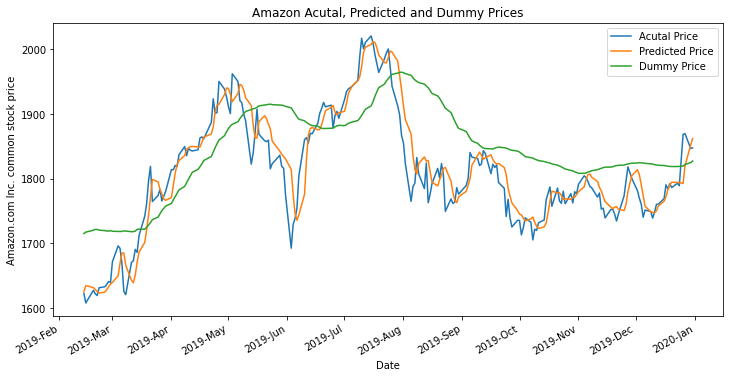

In [20]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

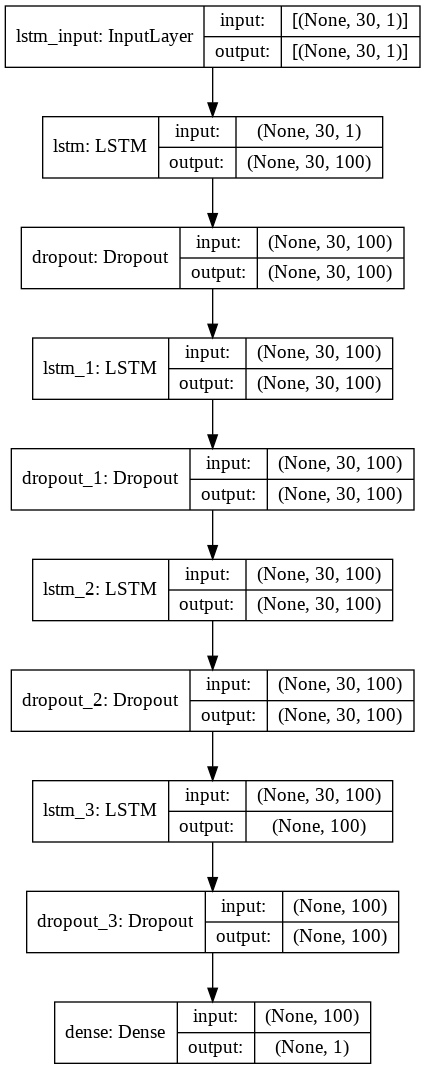

In [21]:
plot_model(model, show_shapes=True, expand_nested=True)

In [22]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.018966039467459752
RMSE:  0.13771724462629853
MAE:  0.11954189538351413


In [23]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Amazon/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Amazon/assets
